In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Q1) Write a function that will shift an array by an arbitrary amount using a convolution. The function should take 2 arguments, an array and an amount by which to shift the array. Plot a gaussian that started in the centre of the array shifted by half the array length, in "gauss_shift.png".

Shifting an array {$x_n$} by an amount $m$ just amounts to taking the inverse Fourier transform ($F^{-1}$) of $e^{-2\pi i k m/N}$ (which is just the Fourier transform of a delta function), for $N$ the total number of points and $k\in[0,N-1]$, multiplied by the Fourier transform ($F$) of the original array ({$x_n$}), which we can write as {$X_k$}. This relation can written as, 

\begin{equation}
\{x_{n-m}\} = F^{-1}(\{\text{exp}(-\frac{i 2 \pi k m}{N})\cdot X_k \})_n
\end{equation}

and is implemented in the function `shift` below.

In [198]:
def shift(arr, m):
    arr_dft = np.fft.fft(arr)
    N = len(arr)
    k = np.arange(N) # integers from 0 to N-1
    shift_func = np.exp(-2j*k*np.pi*m/N)
    arr_shifted = np.fft.ifft(shift_func*arr_dft)
    r_arr_shifted = np.real(arr_shifted) # take real part for plotting
    return r_arr_shifted

def gaussian(x, mu=0, sigma=1): # Gaussian with mean=0, sigma=1
    return np.exp(-(x-mu)**2 /(2*sigma**2))# / (sigma*(2*np.pi)**(1/2))

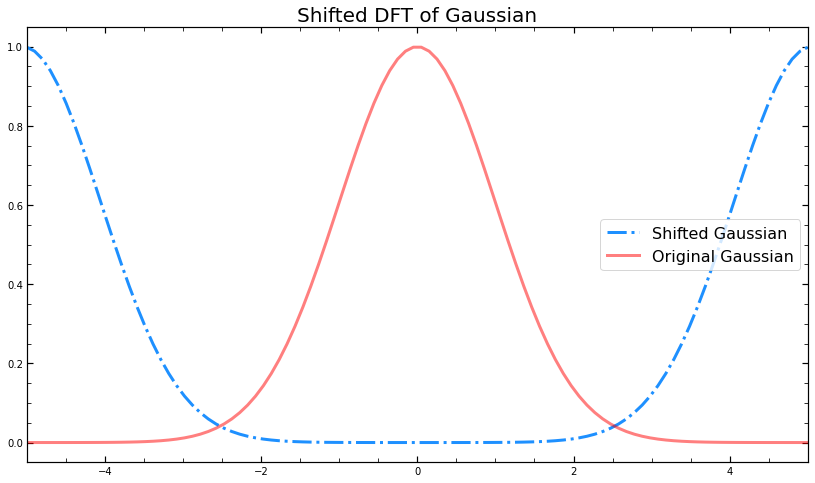

In [252]:
# Shift gaussian by half the array length

size_arr = 100
xx = np.linspace(-5, 5, size_arr)
gauss_arr = gaussian(xx)
shift_size = size_arr/2 # m
shifted_arr = shift(gauss_arr, shift_size)

fig, ax = plt.subplots(figsize=[14,8])
ax.plot(xx, shifted_arr, lw=3, linestyle='-.', color='dodgerblue', label='Shifted Gaussian')
ax.plot(xx, gauss_arr, lw=3, color='red', alpha=0.5, label='Original Gaussian')
ax.legend(fontsize=16)
ax.set_xlim(xmin=xx[0], xmax=xx[-1])
ax.set_title('Shifted DFT of Gaussian', fontsize=20);
#fig.savefig('gauss_shift.png');

# Q2) The correlation function $f\star g$ is $\int f(x)g(x+y) dx$. Through a proof similar to the one we saw for the convolution theorem, one can show $f\star g$=$F^{-1}(F(f)*conj(F(g)))$ (all discrete of course). Write a routine to take the correlation function of two arrays. Plot the correlation function of a Gaussian with itself.

We can obtain the correlation function following the inverse DFT of the DFT of $f$ multiplied by the complex conjugate of the DFT of $g$ (the conjugate DFT just amounts to taking the DFT of $g(-x)$, which for an array  simply implies taking the DFT of the flipped array, having assumed $g(x)$ (equivalently the array) to be real). 

In [266]:
def corr2arr(arr1,arr2):
    ft_arr1 = np.fft.fft(arr1)
    conj_ft_arr2 = np.fft.fft(arr2[::-1]) # conjugate DFT is DFT of flipped array for real array
    corr_arr12 = np.fft.ifft(ft_arr1*conj_ft_arr2)
    r_corr_arr12 = np.real(corr_arr12) # take real part for plotting
    return r_corr_arr12/np.max(r_corr_arr12) # norm so easy to compare with original Gaussian

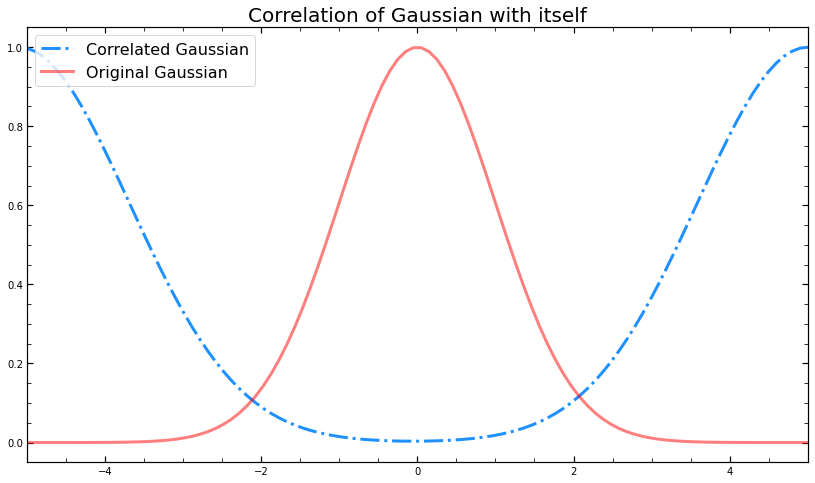

In [267]:
# Plot correlation function of a Gaussian with itself

size_arr2 = 100
xx2 = np.linspace(-5, 5, size_arr2)
gauss_arr2 = gaussian(xx2)
gauss_corr = corr2arr(gauss_arr2,gauss_arr2)

fig1, ax1 = plt.subplots(figsize=[14,8])
ax1.plot(xx2, gauss_corr, lw=3, linestyle='-.', color='dodgerblue', label='Correlated Gaussian')
ax1.plot(xx2, gauss_arr2, lw=3, color='red', alpha=0.5, label='Original Gaussian')
ax1.legend(fontsize=16)
ax1.set_xlim(xmin=xx2[0], xmax=xx2[-1])
ax1.set_title('Correlation of Gaussian with itself', fontsize=20);
#fig.savefig('correlation_Gaussian.png');

# Q3) Using the results from part 1 and part 2, write a routine to take the correlation function of a Gaussian (shifted by an arbitrary amount) with itself. How does the correlation depend on the shift? Does this surprise you?

In [194]:
def corr_shift_gauss(x, m):
    gauss_array = gaussian(x)
    shifted_gauss_array = shift(gauss_array, m)
    gauss_shift_corr = corr2arr(shifted_gauss_array, gauss_array)
    r_gauss_shift_corr = np.real(gauss_shift_corr)
    return [gauss_array, shifted_gauss_array, r_gauss_shift_corr/np.max(r_gauss_shift_corr)] # 3 arrays to plot

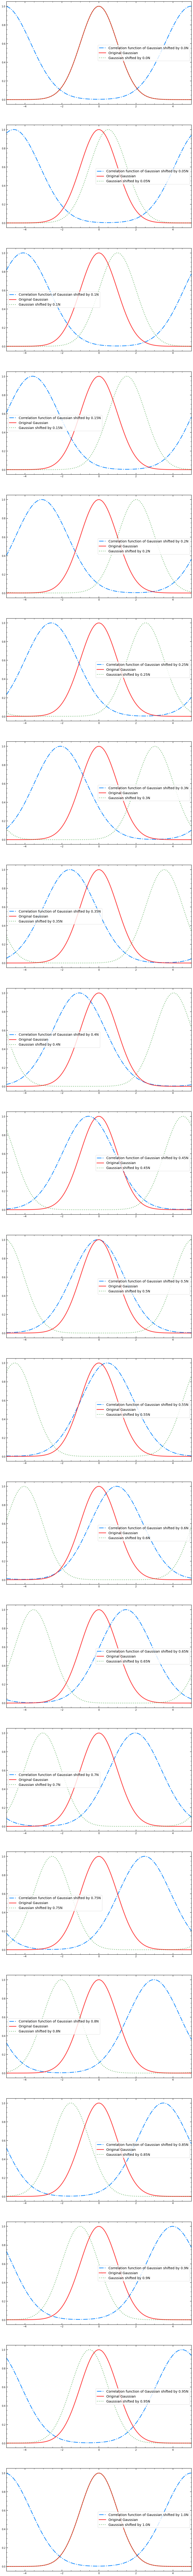

In [195]:
size_arr3 = 100
xx3 = np.linspace(-5, 5, size_arr3)
shifts = np.arange(0,101,5)
num_shifts=len(shifts)

fig2, ax2 = plt.subplots(num_shifts,figsize=[14,200])

for i in range(num_shifts): 
    reg_gauss, shifted_gauss, gauss_shift_corr = corr_shift_gauss(xx3,shifts[i])
    ax2[i].plot(xx3, gauss_shift_corr, lw=3, linestyle='-.', color='dodgerblue', label='Correlation function of Gaussian shifted by '+repr(shifts[i]/size_arr3)+'N')
    ax2[i].plot(xx3, reg_gauss, lw=3, color='red', alpha=0.75, label='Original Gaussian')
    ax2[i].plot(xx3, shifted_gauss, lw=3, linestyle=':', color='green', alpha=0.5, label='Gaussian shifted by '+repr(shifts[i]/size_arr3)+ 'N')
    ax2[i].legend(fontsize=14)
    ax2[i].set_xlim(xmin=xx2[0], xmax=xx2[-1])

#fig.savefig('shifted_corr_Gaussian.png');

The correlation function is a minimum when the maxima of the original and shifted Gaussian completely overlap (which occurs for a shift of an integer multiple of N), and a maximum when the minima overlap. This unexpected behaviour is likely due to the circulant nature of the DFT, which results a correlation function that is not doing what we would intuitively expect. This behaviour arises due to the implicit assumption of DFTs, that the signal/function/array is periodic with period N. 


# Q4) The circulant (wrap-around) nature of the DFT can sometimes be problematic. Write a routine to take the convolution of two arrays without any danger of wrapping around. You may wish to add zeros to the end of the input arrays. Call your routine `conv_safe(f,g)`, where $f$ and $g$ are not necessarily the same length. How long is the output array?

We can add zeros to the end of input arrays to avoid circular convolution/correlation, and obtain the desired linear convolution. This is due to the fact that 'padding' the signal/array with zeros effectively returns us to the assumption that the signal/array is zero outside of the known range (where the standard DFT assumption is periodicity outside of the known range). Therefore, the new signal/array is periodic with period $N+N_0$, for $N_0$ the number of zeros we have appended to the signal/array.

In [333]:
def conv_safe(f,g):
    N_f = len(f)
    N_g = len(g)
    
    if N_f<N_g:
        g_padsize=N_g-N_f
        f_padsize=2*g_padsize
    elif N_f>N_g:
        f_padsize=N_f-N_g
        g_padsize=2*f_padsize
    else:
        f_padsize=N_f
        g_padsize=N_f

    ft_pad_f = np.fft.fft(np.pad(f, [0,f_padsize+5])) # pad with an extra 5 zeros for cases where len is small
    ft_pad_g = np.fft.fft(np.pad(g, [0,g_padsize+5]))
    conv = np.fft.ifft(ft_pad_f*ft_pad_g)
    conv_real = np.real(conv)
    
    return conv_real / conv_real.max() # take real for plotting

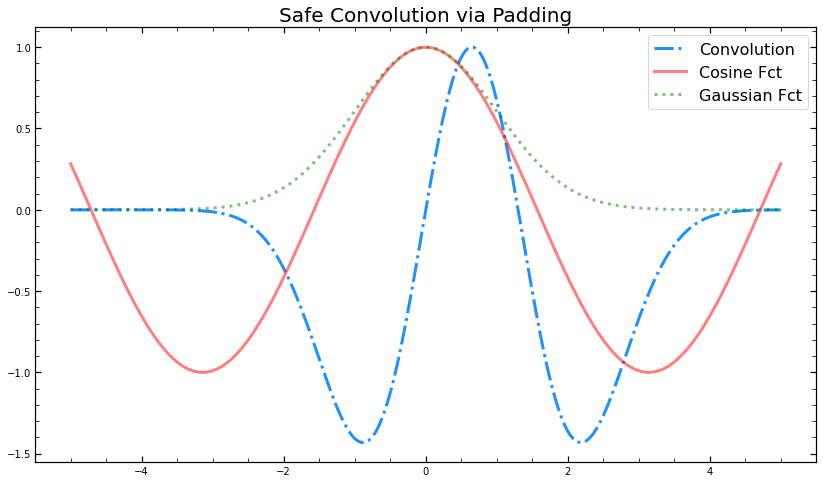

In [334]:
# Plot correlation function of a Gaussian with itself

size_arr4 = 122
size_arr5 = 201
xx4 = np.linspace(-5, 5, size_arr4)
xx5 = np.linspace(-5, 5, size_arr5)
#gauss_arr4 = gaussian(xx4)
gauss_arr5 = gaussian(xx5)
cos_arr4 = np.cos(xx4)
conv4 = conv_safe(cos_arr4,gauss_arr5)

if 1:
    fig4, ax4 = plt.subplots(figsize=[14,8])
    ax4.plot(np.linspace(-5,5, len(conv4)), conv4, lw=3, linestyle='-.', color='dodgerblue', label='Convolution')
    ax4.plot(xx4,cos_arr4, lw=3, color='red', alpha=0.5, label='Cosine Fct')
    ax4.plot(xx5,gauss_arr5, lw=3, linestyle=':', color='green', alpha=0.5, label='Gaussian Fct')
    ax4.legend(fontsize=16)
    #ax4.set_xlim(xmin=xx2[0], xmax=xx2[-1])
    ax4.set_title('Safe Convolution via Padding', fontsize=20);
    #fig.savefig('safe_convolution.png');

The output array with be twice the size of the smaller array plus 5, given we padded each array with an additional 5 zeros.

# Q5a) DFTs work nicely out of the box when there are an integer number of period of a wave in theregion analyzed. Sadly, when we are dealing with real data we usually are forced to analyze a finite chunk of data, and there will in general be no particular relation between the frequencies in the data and the interval we're analyzing. We'll look at the effects of this a bit now. Show that $\sum_{x=0}^{N-1} \text{exp}(-2\pi i kx/N) =  \frac{1-\text{exp}(-2\pi ik)}{1-\text{exp}(-2\pi ik/N)}$.

This can be done by recognizing that the sum can be written as the sum of a geometric series. Expanding the series out we get, 

\begin{equation}
\sum_{x=0}^{N-1} \text{exp}(-2\pi i kx/N) =1+e^{-2\pi i k/N} +e^{-4\pi i k/N}+e^{-6\pi i k/N} + .... = \sum_{x=0}^{N-1} \text{exp}(-2\pi i k/N)^x
\end{equation}

which is very similar to the geometric series closed-form formula, 

\begin{equation}
\sum_{x=0}^{N} ar^x  = a \left( \frac{1-r^{N+1}}{1-r} \right) \implies a = 1 \,\,\,\, \text{and} \,\,\,\, r=\text{exp}(-2\pi i k/N)
\end{equation}

and noting our sum runs from $[0,N-1]$, we can rewrite our series in similar form as, 

\begin{equation}
\sum_{x=0}^{N-1} \text{exp}(-2\pi i k/N)^x  = \left( \frac{1-\text{exp}(-2\pi i k/N)^{N+1-1}}{1-\text{exp}(-2\pi i k/N)} \right)  = \frac{1-\text{exp}(-2\pi i k)}{1-\text{exp}(-2\pi i k/N)}.
\end{equation}

# Q5b) Show that this approaches $N$ as $k$ approaches zero, and is zero for any integer k that is not a multiple of $N$.

Taking the limit as $k \rightarrow 0$ we get, 

\begin{equation}
\lim_{k\to 0} \frac{1-\text{exp}(-2\pi i k)}{1-\text{exp}(-2\pi i k/N)} =  \lim_{k\to 0} \frac{(2\pi i)\text{exp}(-2\pi i k)}{(\frac{2\pi i}{N})\text{exp}(-2\pi i k/N)} = \lim_{k\to 0} \frac{N \text{exp}(-2\pi i k)}{\text{exp}(-2\pi i k/N)} = \frac{N\text{exp}(0)}{\text{exp}(0)} = N
\end{equation}

after applying L'hopital's rule.

Now we can show that the limit as $k\rightarrow n$ for $\{n: n \in \mathbb{Z}, n\neq mN , m\in \mathbb{Z}\}$. This limit is, 

\begin{equation}
\lim_{k\to n} \frac{1-\text{exp}(-2\pi i k)}{1-\text{exp}(-2\pi i k/N)} = \frac{1-1}{1-\text{exp}(-2\pi i n/N)} = \frac{0}{1-\text{exp}(-2\pi i n/N)}  = 0
\end{equation}

given the denominator is only $0$ for $n$ being an integer multiple of $N$ (where we recover the result from the limit above), however, for all $n$ not an integer multiple of $N$ we have a non-zero denominator given,

\begin{equation}
\text{exp}(-2\pi i n/N)\neq 1 \,\, \forall \,\, \frac{n}{N} \notin \mathbb{Z}
\end{equation}

and hence the limit evaluates to 0 given the 0 in the numerator.

# Q5c) We can use this to analytically write down the DFT of a non-integer sine wave. Pick a non-integer value for $k$ and plot your analytic estimate of the DFT. Show that the FFT agrees (to within machine precision) with your analytic estimate. Normally, we think of the Fourier transform of a pure sine wave to a delta function.  Are we close to that? This phenomenon is usually known as spectral leakage.

Considering a non-integer value of $k$ in our sine function, $f(x) = \text{sin}(2\pi k x /N)$, we can write down the Fourier transform, $F(k')$, of $f(x)$ as, 

\begin{equation}
F(k') = \sum_{x=0}^{N-1} f(x) \text{exp}(-2\pi i k'x/N) = \sum_{x=0}^{N-1} \text{sin}(2\pi k x/N)\text{exp}(-2\pi i k'x/N)
\end{equation}

where we can use the trigonometric identity for sine to simplify. This gives us, 

\begin{equation}
F(k') = \sum_{x=0}^{N-1} \left( \frac{e^{2\pi i kx/N} - e^{-2\pi i k x/N}}{2i}\right) \text{exp}(-2\pi i k'x/N) = \sum_{x=0}^{N-1} \left( \frac{e^{2\pi i (k-k')x/N} - e^{-2\pi i (k+k')x/N}}{2i}\right)  = \frac{1}{2i} \left( \sum_{x=0}^{N-1} e^{-2\pi i (k'-k)x/N} - \sum_{x=0}^{N-1} e^{-2\pi i (k+k')x/N} \right) .
\end{equation}

Writing these sums as we evaluated them in $b$ we get, 

\begin{equation}
F(k') = \frac{1}{2i} \left( \frac{1-\text{exp}(-2\pi i (k'-k))}{1-\text{exp}(-2\pi i (k'-k)/N)} - \frac{1-\text{exp}(-2\pi i (k+k'))}{1-\text{exp}(-2\pi i (k+k')/N)} \right).
\end{equation}



In [341]:
def ft_analytic_sine(x,k):
    N = len(x)
    kprime = np.arange(N)
    ft_sine = np.zeros(N)
    for i in range(len(kprime)):
        #ft_sine[i] = (1/(2j))*np.sum(np.exp(-2j*np.pi*(kprime[i]-k)*x/N) - np.exp(-2j*np.pi*(k+kprime[i])*x/N))
        ft_sine[i] = (1/(2j))*((1-np.exp(-2j*np.pi*(kprime[i]-k)))/(1-np.exp(-2j*np.pi*(kprime[i]-k)/N)) 
                             - (1-np.exp(-2j*np.pi*(k+kprime[i])))/(1-np.exp(-2j*np.pi*(k+kprime[i])/N)))
        
    return np.real(ft_sine), kprime

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


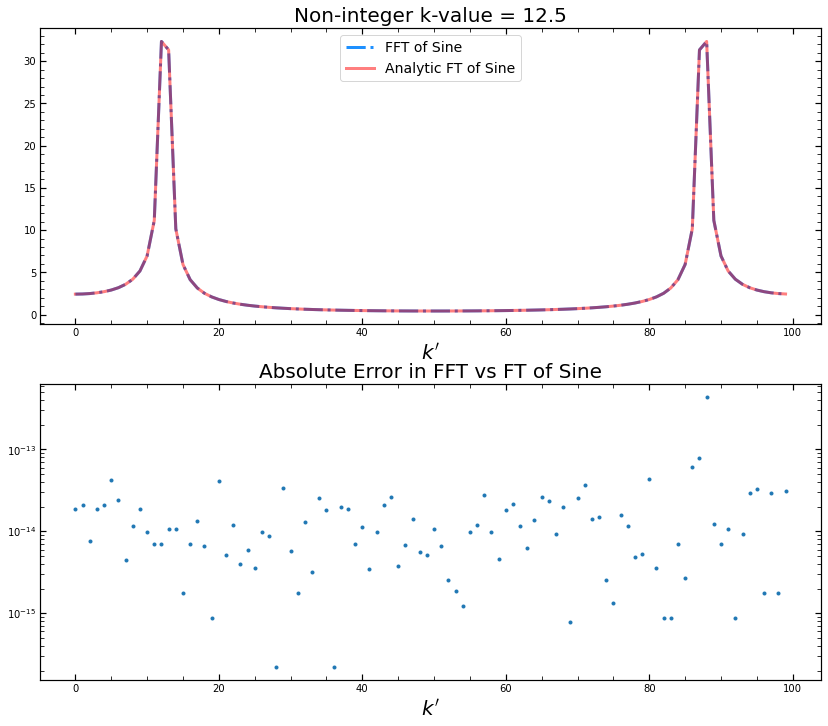

In [356]:
# Now set a k = non-integer

k=12.5
N=100
xx6 = np.arange(N)
sine = np.sin(2*np.pi*k*xx6/N)
fft_sine = np.real(np.fft.fft(sine)) # FFT of sine function
analytic_ft_sine, kprime = ft_analytic_sine(xx6,k) # analytic FT of sine
err = np.abs(analytic_ft_sine-fft_sine) # residuals

fig5, ax5 = plt.subplots(2,figsize=[14,12])

ax5[0].plot(kprime, np.abs(fft_sine), lw=3, linestyle='-.', color='dodgerblue', label='FFT of Sine')
ax5[0].plot(kprime, np.abs(analytic_ft_sine), lw=3, color='red', alpha=0.5, label='Analytic FT of Sine')
ax5[0].set_xlabel("$k'$", fontsize=20)
ax5[0].legend(fontsize=14)
ax5[0].set_title('Non-integer k-value = '+repr(k), fontsize=20)
ax5[1].plot(kprime, err, '.')
ax5[1].set_title('Absolute Error in FFT vs FT of Sine', fontsize=20)
ax5[1].set_xlabel("$k'$", fontsize=20)
ax5[1].set_yscale('log')

Clearly, the FFT agrees very well with our analytic expression for the FT of a non-integer sine wave. Given the error is on the order of $\approx 10^{-14}$, this is around machine precision. In the first plot for the non-integer k-value we have something similar to a delta function, although it appears to be somewhat spread out relative to the standard spike. It may be noted that the two spike are occuring where expected, at $k'=k$ and $k'=-k$. Increasing the number of points in $x$ and hence $k'$ we would likely see smoother spikes that more closely resemble delta functions.

# Q5d) A common tool to get around this is the use of window functions. The leakage is essentially from the fact that we have a sharp jump at the edge of the interval. If we multiply our input data by a function that goes to zero at the edges, this cancels out the jump, and so prevents the leakage from the jumps at the edges. This effectively means we have convolved by the function in Fourier space. One simple window to use is $0.5-0.5cos(2\pi x/N)$. Show that when we multiply by this window, the spectral leakage for a non-integer period sine wave drops dramatically.

Text(0.5, 1.0, 'Non-integer k-value = 12.5 with Window Function Multiplication')

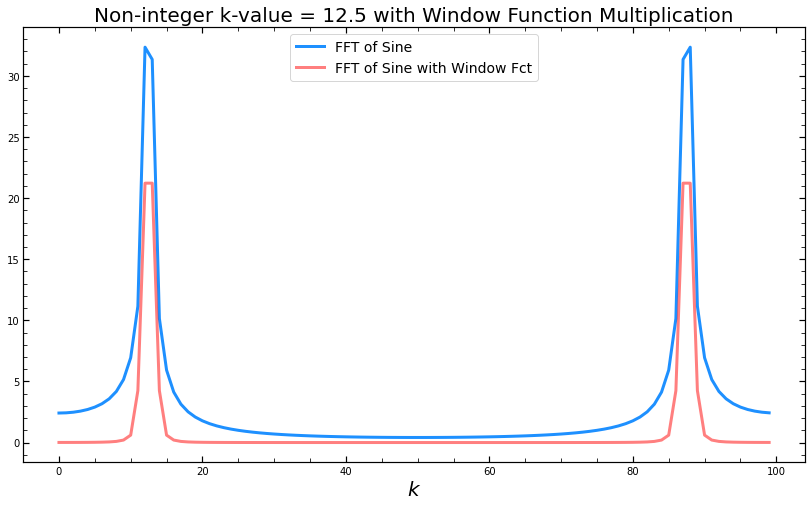

In [352]:
# Multiply by a window function

k=12.5
xx7 = np.arange(100)
N = len(xx7)
window_fct = 0.5-0.5*np.cos(2*np.pi*xx7/N)
sine = np.sin(2*np.pi*k*xx7/N)
fft_sine_window = np.real(np.fft.fft(sine*window_fct)) # FFT of sine function * window function


fig6, ax6 = plt.subplots(figsize=[14,8])

ax6.plot(xx7, np.abs(fft_sine), lw=3,color='dodgerblue', label='FFT of Sine')
ax6.plot(xx7, np.abs(fft_sine_window), lw=3, color='red', alpha=0.5, label='FFT of Sine with Window Fct')
ax6.set_xlabel('$k$', fontsize=20)
ax6.legend(fontsize=14)
ax6.set_title('Non-integer k-value = '+repr(k)+ ' with Window Function Multiplication', fontsize=20)

As we see above, the multiplication of sine by the suggested window function drastically reduces the spectral leakage we observed in $c$. We can see this directly on the above plot, where the two 'delta' functions for the FFT of sine multipled by the window function exhibit the characteristic 'spike' shape far more than the spikes resulting from the direct FFT of sine.

# Q5e) As we saw in class, show that the Fourier transform of the window is [N/2 - N/4 0 ... 0 - N/4] (either numerically or analytically). Use this to show that you can get the windowed FT by appropriate combinations of each point in the unwindowed FT and its immediate neighbours.

Text(0.5, 1.0, 'FFT of $f(x) = 0.5-0.5cos(2\\pi x/N)$')

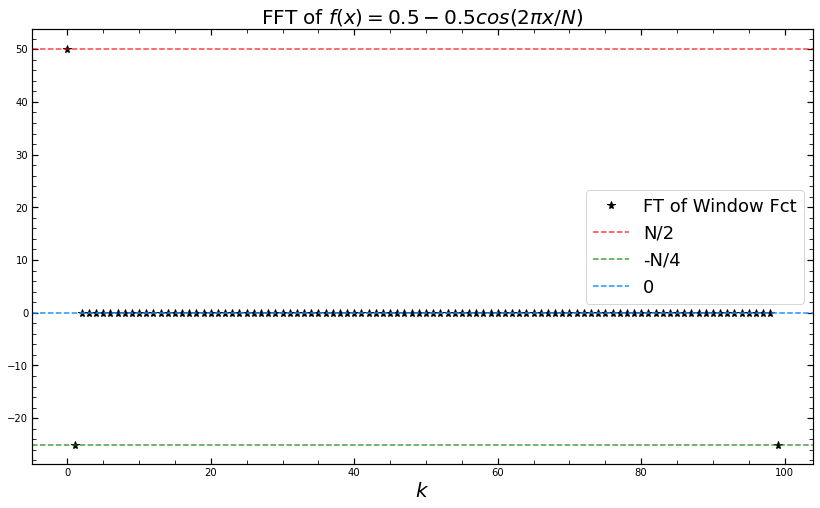

In [354]:
N = len(xx7)
ft_window = np.real(np.fft.fft(window_fct))

fig7, ax7 = plt.subplots(figsize=[14,8])

ax7.plot(ft_window, '*', color='black', markersize=8,label='FT of Window Fct')
ax7.axhline(y=N/2, linestyle='--', color='red', alpha=0.75, label='N/2')
ax7.axhline(y=-N/4, linestyle='--', color='green', alpha=0.75, label='-N/4')
ax7.axhline(y=0, linestyle='--', color='dodgerblue', label='0')
ax7.legend(fontsize=18)
ax7.set_xlabel('$k$', fontsize=20)
ax7.set_title('FFT of $f(x) = 0.5-0.5cos(2\pi x/N)$', fontsize=20)
#fig7.savefig('q5e_window_ft.png');

Our window function there takes on only 3 possible values, given it is zero (or within machine precision of zero) for all points outside of the first 2 points and the last point. Therefore, we can write our function as, 

\begin{equation}
F(\text{Window}(x))_k = F_{\text{Wind}}(k)  =  \left\{
\begin{array}{ll}
      \frac{N}{2} & k=0 \\
      \frac{-N}{4} & k=1,-1 \\
      0 & \text{otherwise} \\
\end{array} 
\right.
\end{equation}

where the Fourier transform is circulant and hence, $k=-1$ is just the last point in the array above, which we showed had a value of $-N/4$. Rewriting this as a single equation of unit sample functions (delta function with value 1 for an argument of 0), we get, 

\begin{equation}
F_{\text{Wind}}(k) = \frac{N}{2}\delta(k) - \frac{N}{4}\delta(k-k') - \frac{N}{4}\delta(k+k').
\end{equation}


\begin{equation}
\implies F(k')  =  \left\{
\begin{array}{ll}
      \frac{N}{2i} & k'=k \\
      \frac{-N}{2i} & k'=-k \\
      0 & \text{otherwise} \\
\end{array} 
\right.
\end{equation}

given we had proven above that the sums evaluated to $N$ for $k \rightarrow 0$, which has now been replaced by $(k'-k)$ and $(k+k')$. Whenever, $(k'-k)$ and $(k+k')$ are not 0, the two sums evaluate to zero given we initially considered a scenario where $k\notin \mathbb{Z}$, and hence the limit we evaluated in the second part of $b$ holds.